In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.operators import total_mass, total_momentum, total_energy_k, total_L2_norm
from operators.operators import solve_poisson_equation, psi_ln_sw, solve_poisson_equation, fft_, J_matrix_inv
from operators.operators import integral_I1, integral_I2, integral_I0, linear_2_two_stream_SW
from operators.closure import closure_momentum, closure_energy, closure_mass

In [3]:
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib.pylab as pl
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Langmuir Wave SW 

In [6]:
# set up configuration parameters
# number of Fourier spectral terms in x
Nx = 50
Nx_total = 2 * Nx + 1
# number of Hermite spectral terms in v
Nv = 1001
# Velocity scaling of electron and ion
alpha_e = 0.1
alpha_i = np.sqrt(1 / 1836)
# perturbation magnitude
epsilon = 0.01
# x grid is from 0 to L
L = 2 * np.pi
# final time
T = 100
# time stepping
dt = 0.1
# time vector
t_vec = np.linspace(0, T, int(T / dt) + 1)
# velocity scaling
u_e = 1
u_i = 1
# mass normalized
m_e = 1
m_i = 1836
# charge normalized
q_e = -1
q_i = 1
# closure
closure = "truncation"

In [7]:
# inverse J
J_inv = J_matrix_inv(Nx=Nx, L=L)

In [8]:
# velocity grid for plotting purposes
v = np.linspace(0.5, 1.5, int(1e3))
# spatial grid 
x_project = np.linspace(0, L, int(1e5))
x = np.linspace(0, L, Nx_total)

## read in simulation results

In [9]:
sol_midpoint_u = np.load("../data/SW/langmuir/sol_midpoint_u_" + str(Nv) + "_" + str(closure) + "_closure.npy")
sol_midpoint_t = np.load("../data/SW/langmuir/sol_midpoint_t_" + str(Nv) + "_" + str(closure) + "_closure.npy")
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(202209, 1001)
(1001,)


In [10]:
# initialize the electric potential
E_midpoint = np.zeros((Nx_total, len(sol_midpoint_t)), dtype="complex128")

In [11]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((Nv, Nx_total, len(sol_midpoint_t)), dtype="complex128")
state_i_midpoint = np.zeros((Nv, Nx_total, len(sol_midpoint_t)), dtype="complex128")

closure_e = np.zeros((Nx_total, len(sol_midpoint_t)), dtype="complex128")
closure_i = np.zeros((Nx_total, len(sol_midpoint_t)), dtype="complex128")

for ii in range(len(sol_midpoint_t)):
    for jj in range(Nv):
        # unwind the flattening in order to solve the linear system
        state_e_midpoint[jj, :, ii] = sol_midpoint_u[jj * Nx_total: (jj + 1) * Nx_total, ii]
        state_i_midpoint[jj, :, ii] = sol_midpoint_u[Nv * Nx_total + jj * Nx_total: Nv * Nx_total + (jj + 1) * Nx_total, ii]

    E_midpoint[:, ii] = solve_poisson_equation(state_e=state_e_midpoint[:, :, ii],
                                               state_i=state_i_midpoint[:, :, ii],
                                               alpha_e=alpha_e, alpha_i=alpha_i, Nx=Nx, L=L, Nv=Nv)
    # energy closure
    if closure == "energy":
        closure_e = closure_energy(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, u_s=u_e, Nv=Nv, E=E_midpoint[:, ii], J_inv=J_inv, q_s=q_e, m_s=m_e, Nx_total=Nx_total, Nx=Nx)
        closure_i = closure_energy(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, u_s=u_i, Nv=Nv, E=E_midpoint[:, ii], J_inv=J_inv, q_s=q_i, m_s=m_i, Nx_total=Nx_total, Nx=Nx)

    # momentum closure
    elif closure == "momentum":
        # momentum closure
        closure_e = closure_momentum(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, u_s=u_e, Nv=Nv)
        closure_i = closure_momentum(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, u_s=u_i, Nv=Nv)

    # total mass closure
    elif closure == "mass":
        #  mass closure
        closure_e = closure_mass(state=state_e_midpoint[:, :, ii], E=E_midpoint[:, ii], Nx=Nx)
        closure_i = closure_mass(state=state_i_midpoint[:, :, ii],  E=E_midpoint[:, ii], Nx=Nx)

    # truncation
    elif closure == "truncation":
        #  mass closure
        closure_e = np.zeros(Nx_total)
        closure_i = np.zeros(Nx_total)

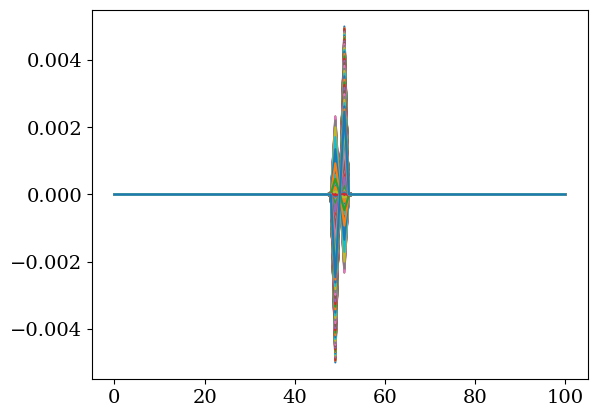

In [12]:
_  = plt.plot(E_midpoint[:, :].imag)

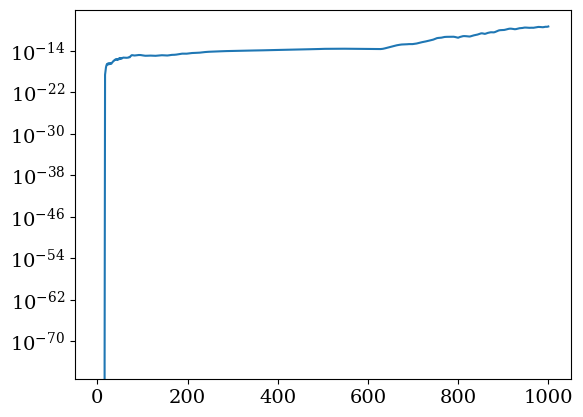

In [13]:
plt.plot(np.linalg.norm(state_e_midpoint[-1, :, :], axis=0))
plt.yscale("log")

In [14]:
E_field = np.zeros(np.shape(E_midpoint))
for ii in range(len(sol_midpoint_t)):
    E_field[:, ii] = fft_(E_midpoint[:, ii], Nx, x, L)

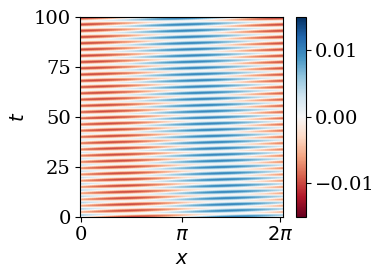

In [24]:
fig, ax = plt.subplots(figsize=(4, 3))
pos = ax.pcolormesh(x, sol_midpoint_t, E_field.T, cmap="RdBu", vmin=-0.015, vmax=0.015)
cbar = fig.colorbar(pos)
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

plt.savefig("../figs/SW/langmuir/electric_field_SW_" + str(closure) + "_" + str(Nv) + ".png", dpi=600)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_4608/160191009.py:2: RuntimeWarning: divide by zero encountered in log10
  pos = ax.pcolormesh(np.arange(1, 11), sol_midpoint_t, np.log10(np.abs(E_midpoint[Nx+1:Nx+11, :])).T, cmap="viridis", vmax=-1, vmin=-10)


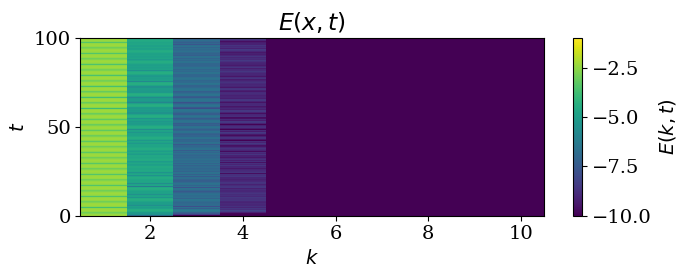

In [16]:
fig, ax = plt.subplots(figsize=(7, 3))
pos = ax.pcolormesh(np.arange(1, 11), sol_midpoint_t, np.log10(np.abs(E_midpoint[Nx+1:Nx+11, :])).T, cmap="viridis", vmax=-1, vmin=-10)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel("$E(k, t)$", rotation=90)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$k$")
# _ = ax.set_xticks([0, np.pi, 2*np.pi-.05])
# _ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

plt.savefig("../figs/SW/langmuir/electric_field_SW_" + str(closure) + "_" + str(Nv) + ".png", dpi=600)

In [17]:
E1_midpoint = np.zeros(len(sol_midpoint_t))
E2_midpoint = np.zeros(len(sol_midpoint_t))
E3_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(len(sol_midpoint_t)):
    E1_midpoint[ii] = np.abs(E_midpoint[Nx+1, ii])
    E2_midpoint[ii] = np.abs(E_midpoint[Nx+2, ii])
    E3_midpoint[ii] = np.abs(E_midpoint[Nx+3, ii])

In [18]:
np.save("../data/SW/langmuir/E1_midpoint_" + str(closure) + "_" + str(Nv) + ".npy", E1_midpoint)
np.save("../data/SW/langmuir/E2_midpoint_" + str(closure) + "_" + str(Nv) + ".npy", E2_midpoint)
np.save("../data/SW/langmuir/E3_midpoint_" + str(closure) + "_" + str(Nv) + ".npy", E3_midpoint)
np.save("../data/SW/langmuir/E_field_" + str(closure) + "_" + str(Nv) + ".npy", E_field)

In [19]:
E1_midpoint_truncation_51 = np.load("../data/SW/langmuir/E1_midpoint_truncation_51.npy")
E1_midpoint_truncation_11 = np.load("../data/SW/langmuir/E1_midpoint_truncation_11.npy")
E1_midpoint_momentum_11 = np.load("../data/SW/langmuir/E1_midpoint_momentum_11.npy")
E1_midpoint_energy_11 = np.load("../data/SW/langmuir/E1_midpoint_energy_11.npy")
E1_midpoint_mass_11 = np.load("../data/SW/langmuir/E1_midpoint_mass_11.npy")

E2_midpoint_truncation_11 = np.load("../data/SW/langmuir/E2_midpoint_truncation_11.npy")
E2_midpoint_momentum_11 = np.load("../data/SW/langmuir/E2_midpoint_momentum_11.npy")
E2_midpoint_energy_11 = np.load("../data/SW/langmuir/E2_midpoint_energy_11.npy")
E2_midpoint_mass_11 = np.load("../data/SW/langmuir/E2_midpoint_mass_11.npy")

E3_midpoint_truncation_11 = np.load("../data/SW/langmuir/E3_midpoint_truncation_11.npy")
E3_midpoint_momentum_11 = np.load("../data/SW/langmuir/E3_midpoint_momentum_11.npy")
E3_midpoint_energy_11 = np.load("../data/SW/langmuir/E3_midpoint_energy_11.npy")
E3_midpoint_mass_11 = np.load("../data/SW/langmuir/E3_midpoint_mass_11.npy")

E_field_truncation_51 = np.load("../data/SW/langmuir/E_field_truncation_51.npy")
E_field_momentum_51 = np.load("../data/SW/langmuir/E_field_momentum_51.npy")
E_field_truncation_11 = np.load("../data/SW/langmuir/E_field_truncation_11.npy")
E_field_momentum_11 = np.load("../data/SW/langmuir/E_field_momentum_11.npy")
E_field_energy_11 = np.load("../data/SW/langmuir/E_field_energy_11.npy")

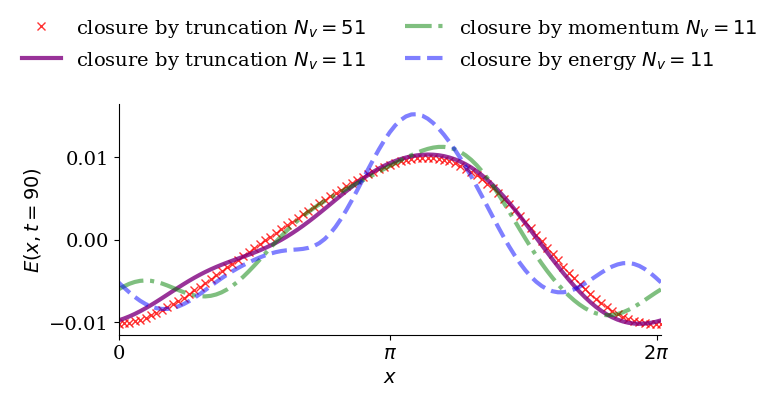

In [20]:
fig, ax = plt.subplots(figsize=(7, 3))
index = 900
ax.plot(x, E_field_truncation_51[:, index], "x", c="red", alpha=0.8, linewidth=3, label="closure by truncation $N_{v}=51$") 
ax.plot(x, E_field_truncation_11[:, index], "-", c="purple", alpha=0.8, linewidth=3, label="closure by truncation $N_{v}=11$") 
ax.plot(x, E_field_momentum_11[:, index], "-.", c="green", alpha=0.5, linewidth=3, label="closure by momentum $N_{v}=11$") 
ax.plot(x, E_field_energy_11[:, index], "--", c="blue", alpha=0.5, linewidth=3, label="closure by energy $N_{v}=11$") 

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$E(x, t=90)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax.set_xlim(0, x[-1])
ax.set_yticks([-0.01, 0, 0.01])
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.45))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.savefig("../figs/SW/langmuir/damping_rate_electric_field.png", bbox_inches='tight', dpi=600)

# Conservation Laws

### mass conservation 

In [21]:
mass_midpoint = np.zeros(len(sol_midpoint_t), dtype="complex128")

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, L=L, Nv=Nv, Nx=Nx)\
                      + total_mass(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, L=L, Nv=Nv, Nx=Nx)

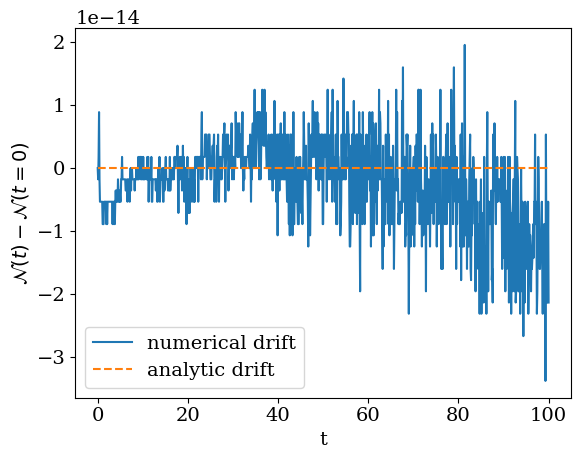

In [22]:
plt.plot(sol_midpoint_t, np.real(mass_midpoint - mass_midpoint[0]), label="numerical drift")
plt.plot(sol_midpoint_t, np.real(sol_midpoint_u[-2]).real, ls="--", label="analytic drift")
plt.ylabel(r"$\mathcal{N}(t)-\mathcal{N}(t=0)$")
plt.xlabel("t")
#plt.yscale("log")
plt.legend()

### momentum conservation

In [23]:
momentum_midpoint_e = np.zeros(len(sol_midpoint_t), dtype="complex128")
momentum_midpoint_i = np.zeros(len(sol_midpoint_t), dtype="complex128")
momentum_midpoint = np.zeros(len(sol_midpoint_t), dtype="complex128")

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint_e[ii] = total_momentum(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, L=L, Nv=Nv, m_s=m_e, u_s=u_e, Nx=Nx)
    momentum_midpoint_i[ii] =  total_momentum(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, L=L, Nv=Nv, m_s=m_i, u_s=u_i, Nx=Nx)             
    
    momentum_midpoint[ii] = momentum_midpoint_e[ii]+ momentum_midpoint_i[ii]


KeyboardInterrupt



In [ ]:
#plt.plot(sol_midpoint_t, np.abs(momentum_midpoint_i))
plt.plot(sol_midpoint_t, np.abs(momentum_midpoint-momentum_midpoint[0]), label="numerical drift")
plt.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-4]), ls="--", label="analytic drift")
plt.ylabel(r"$\mathcal{P}(t)-\mathcal{P}(t=0)$")
plt.xlabel("t")
plt.yscale("log")
plt.legend()

### energy conservation

In [ ]:
energy_k_midpoint = np.zeros(len(sol_midpoint_t), dtype="complex128")
energy_p_midpoint = np.zeros(len(sol_midpoint_t), dtype="complex128")

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, L=L, Nv=Nv, m_s=m_e, u_s=u_e, Nx=Nx)\
                           +total_energy_k(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, L=L, Nv=Nv, m_s=m_i, u_s=u_i, Nx=Nx)

    energy_p_midpoint[ii] = 0.5 * L * np.flip(E_midpoint[:, ii]).T @ E_midpoint[:, ii]

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), label="numerical drift")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-6]), ls="--", label="analytic drift")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='center')
legend.get_frame().set_alpha(0)
plt.tight_layout()

In [ ]:
L2_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    L2_midpoint[ii] = np.abs(total_L2_norm(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, L=L, Nv=Nv))\
                    + np.abs(total_L2_norm(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, L=L, Nv=Nv))

In [ ]:
# plot overall conservation properties 
fig, ax = plt.subplots(ncols=1, figsize=(7, 3))
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-2]), "--", c="orange", linewidth=4, alpha=0.6, label=r"analytic mass")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-4]), "-", c="green", linewidth=4, alpha=0.6, label=r"analytic momentum")
#ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-6]), ":", c="red", linewidth=4, alpha=0.6, label=r"analytic energy")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-7]), "-.", c="pink", linewidth=4, alpha=0.6, label=r"analytic $\mathcal{L}_{2}$")

ax.scatter(sol_midpoint_t[::30], np.abs(mass_midpoint-mass_midpoint[0])[::30], s=30, color="black", label=r"mass")
ax.plot(sol_midpoint_t[::30], np.abs(momentum_midpoint-momentum_midpoint[0])[::30], "x", color="blue", label=r"momentum")
ax.plot(sol_midpoint_t[::30], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::30], ">", color="purple", label=r"energy")
ax.plot(sol_midpoint_t[::30], np.abs(L2_midpoint-L2_midpoint[0])[::30], "*", c="grey", label=r" $\mathcal{L}_{2}$ norm")


ax.set_ylim(10**-14, 10**-1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
#ax.set_xticks([0, 5, 10, 15, 20])
ax.set_xlabel("$t$")
ax.set_xlim(0, sol_midpoint_t[-1])
ax.set_yscale("log")
legend = ax.legend(ncols=3, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.45))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.savefig("../figs/SW/langmuir/conservation_" + str(Nv) + "_langmuir_wave_SW_" + str(closure) + ".png", bbox_inches='tight', dpi=600)